In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.special import expit as sigmoid

# Question 3

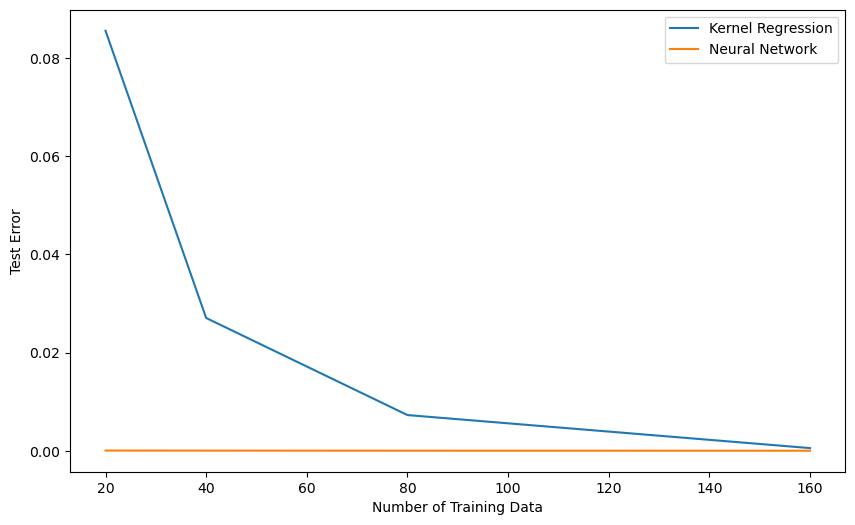

In [13]:
# Define the kernel function
def kernel(x, x_prime, eps=1e-7):
    dot_product = np.dot(x, x_prime)
    return dot_product * (np.pi - np.arccos(np.clip(dot_product, -1+eps, 1-eps))) / (2 * np.pi)
# Generate data
d = 10
m = 5
n_values = [20, 40, 80, 160]
e = np.eye(d)

# Initialize arrays to store test errors
test_errors_kernel = []
test_errors_nn = []

for n in n_values:
    # Generate training data
    X_train = np.random.normal(size=(n, d))
    X_train /= np.linalg.norm(X_train, axis=1, keepdims=True)
    y_train = np.mean(sigmoid(X_train @ e[:m].T), axis=1)

    # Generate test data
    X_test = np.random.normal(size=(1000, d))
    X_test /= np.linalg.norm(X_test, axis=1, keepdims=True)
    y_test = np.mean(sigmoid(X_test @ e[:m].T), axis=1)

    # Kernel regression
    K = kernel(X_train, X_train.T)
    alpha = np.linalg.solve(K, y_train)
    y_pred_kernel = kernel(X_test, X_train.T) @ alpha
    test_errors_kernel.append(mean_squared_error(y_test, y_pred_kernel))

    # Neural network
    w_init = np.random.normal(size=(m, d))
    loss_func = lambda w: np.mean((y_train - np.mean(sigmoid(X_train @ w.reshape(m, d).T), axis=1))**2)
    res = minimize(loss_func, w_init.flatten(), method='L-BFGS-B')
    w_opt = res.x.reshape(m, d)
    y_pred_nn = np.mean(sigmoid(X_test @ w_opt.T), axis=1)
    test_errors_nn.append(mean_squared_error(y_test, y_pred_nn))

# Plot test errors
plt.figure(figsize=(10, 6))
plt.plot(n_values, test_errors_kernel, label='Kernel Regression')
plt.plot(n_values, test_errors_nn, label='Neural Network')
plt.xlabel('Number of Training Data')
plt.ylabel('Test Error')
plt.legend()
plt.show()

# Question 4

In [14]:
train_dataset = torchvision.datasets.MNIST(root='/Users/ekinokos2/datasets/MNIST', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='/Users/ekinokos2/datasets/MNIST', train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [15]:
# Use only the images relating to 0s and 1s
train_dataset = torch.utils.data.Subset(train_dataset, torch.where(train_dataset.targets <= 1)[0])
test_dataset = torch.utils.data.Subset(test_dataset, torch.where(test_dataset.targets <= 1)[0])

# Create a validation set
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)])

In [17]:
# Create a neural network with 2 hidden layers, use batch normalization
class NeuralNetwork(nn.Module):
    def __init__(self, m, H):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, m)
        self.bn1 = nn.BatchNorm1d(m)
        self.fc2 = nn.Linear(m, m)
        self.bn2 = nn.BatchNorm1d(m)
        self.fc3 = nn.Linear(m, 2)
        self.H = H

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        for i in range(self.H):
            x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Create a function to train the neural network
def train(model, train_loader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()

In [18]:
# Create a neural network with 2 hidden layers and leaky ReLU activation function, use batch normalization
class LeakyReLUNeuralNetwork(nn.Module):
    def __init__(self, m, H, alpha):
        super(LeakyReLUNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, m)
        self.bn1 = nn.BatchNorm1d(m)
        self.fc2 = nn.Linear(m, m)
        self.bn2 = nn.BatchNorm1d(m)
        self.fc3 = nn.Linear(m, 2)
        self.H = H
        self.alpha = alpha
        self.leaky_relu = nn.LeakyReLU(self.alpha)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        for i in range(self.H):
            x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

Epoch: 1/5, Training loss: 2.169698382203933e-05, Validation loss: 0.009924979880452156
Epoch: 2/5, Training loss: 1.9599277948145755e-05, Validation loss: 0.009710228070616722
Epoch: 3/5, Training loss: 7.552789156761719e-06, Validation loss: 0.00922161154448986
Epoch: 4/5, Training loss: 3.3760823043849086e-06, Validation loss: 0.010744970291852951
Epoch: 5/5, Training loss: 8.598245585744735e-06, Validation loss: 0.011835223995149136
Epoch: 1/5, Training loss: 3.39570760843344e-05, Validation loss: 0.0070699239149689674
Epoch: 2/5, Training loss: 1.5610014088451862e-05, Validation loss: 0.00518276821821928
Epoch: 3/5, Training loss: 8.052593329921365e-06, Validation loss: 0.005583510268479586
Epoch: 4/5, Training loss: 6.974958068894921e-06, Validation loss: 0.005027165170758963
Epoch: 5/5, Training loss: 5.4824095059302635e-06, Validation loss: 0.005603464785963297


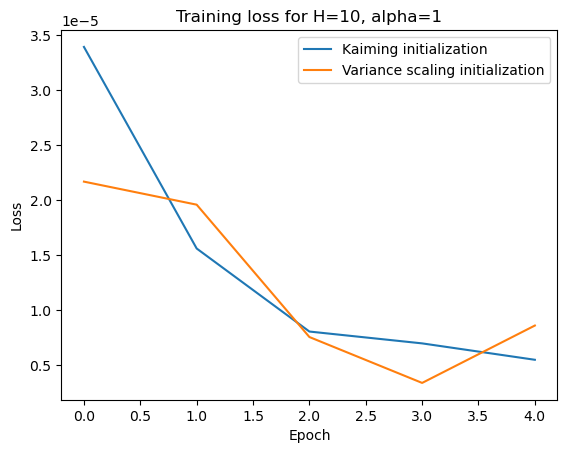

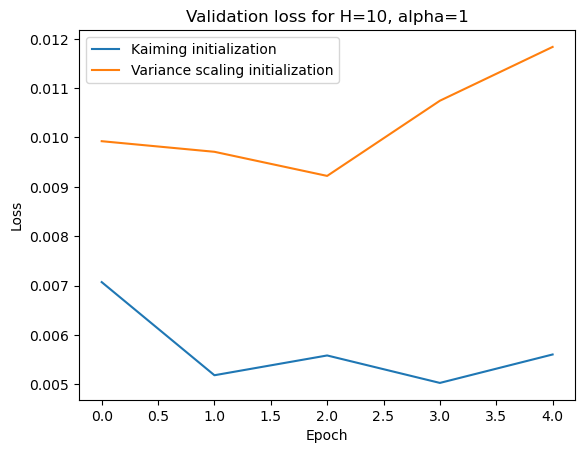

Epoch: 1/5, Training loss: 8.314032129419502e-06, Validation loss: 0.0035353743005543947
Epoch: 2/5, Training loss: 3.1293570827983785e-06, Validation loss: 0.001968442928045988
Epoch: 3/5, Training loss: 2.2377257664629724e-06, Validation loss: 0.0022252195049077272
Epoch: 4/5, Training loss: 3.3736369005055167e-06, Validation loss: 0.0009024913306348026
Epoch: 5/5, Training loss: 1.5006854710009065e-06, Validation loss: 0.0022771786898374557
Epoch: 1/5, Training loss: 3.400937202968635e-05, Validation loss: 0.004066102206707001
Epoch: 2/5, Training loss: 1.286349925067043e-05, Validation loss: 0.004792645573616028
Epoch: 3/5, Training loss: 1.3293359188537579e-05, Validation loss: 0.005548366345465183
Epoch: 4/5, Training loss: 6.68061420583399e-06, Validation loss: 0.00528030376881361
Epoch: 5/5, Training loss: 5.252081336948322e-06, Validation loss: 0.004583280999213457


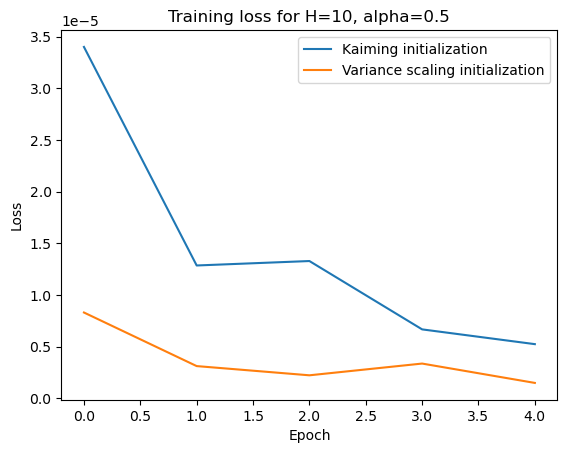

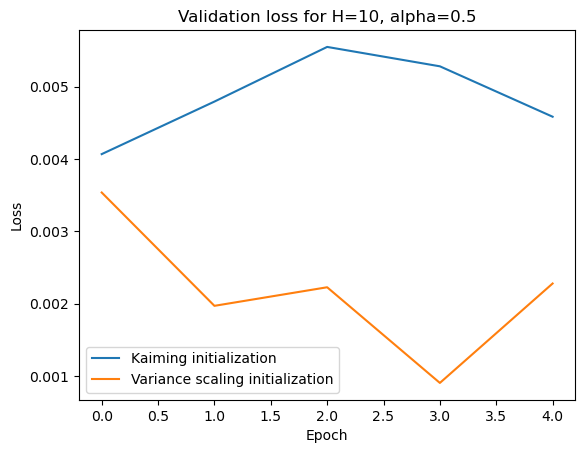

Epoch: 1/5, Training loss: 1.9935265299864113e-05, Validation loss: 0.0011772413272410631
Epoch: 2/5, Training loss: 1.3827245311404113e-05, Validation loss: 0.007150823250412941
Epoch: 3/5, Training loss: 4.167584393144352e-06, Validation loss: 0.005162499845027924
Epoch: 4/5, Training loss: 3.400590003366233e-06, Validation loss: 0.005022942554205656
Epoch: 5/5, Training loss: 2.7402836622059112e-06, Validation loss: 0.007157066371291876
Epoch: 1/5, Training loss: 4.09585190936923e-05, Validation loss: 0.00883151963353157
Epoch: 2/5, Training loss: 1.6903104551602155e-05, Validation loss: 0.007990291342139244
Epoch: 3/5, Training loss: 8.952911230153404e-06, Validation loss: 0.0101599907502532
Epoch: 4/5, Training loss: 6.129390385467559e-06, Validation loss: 0.008265385404229164
Epoch: 5/5, Training loss: 5.61204024052131e-06, Validation loss: 0.009474904276430607


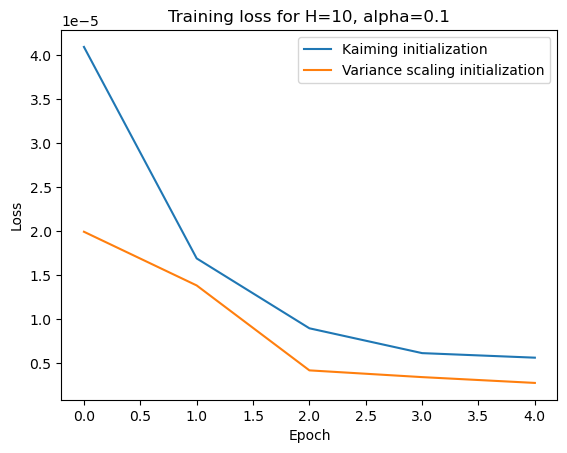

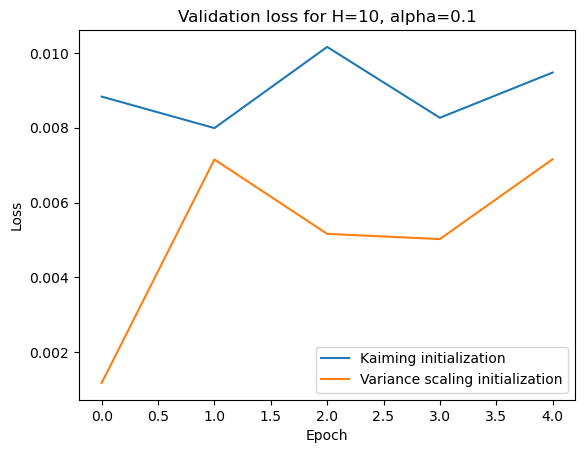

Epoch: 1/5, Training loss: 3.041824311367236e-05, Validation loss: 0.010812745429575443
Epoch: 2/5, Training loss: 2.3529746613348834e-05, Validation loss: 0.009971445426344872
Epoch: 3/5, Training loss: 5.818248155264882e-06, Validation loss: 0.011644324287772179
Epoch: 4/5, Training loss: 0.18573309481143951, Validation loss: 0.1812792867422104
Epoch: 5/5, Training loss: 8.039200110943057e-06, Validation loss: 0.012675853446125984
Epoch: 1/5, Training loss: 4.9348756874678656e-05, Validation loss: 0.00029695298871956766
Epoch: 2/5, Training loss: 4.085246109752916e-05, Validation loss: 0.0035377510357648134


In [37]:
# Define the batch size and learning rate for training
batch_size = 64
lr = 0.01

# Define the number of epochs for training
num_epochs = 5

# Use logistic loss and stochastic gradient descent to train the neural network.
# For this problem, we will fix the width m = 256 for all layers. Consider the four depths H = 10, 20, 30, 40 and four alphas: α = 2, 1, 0.5, 0.1.
H = [10, 20, 30, 40]

alphas = [1, 0.5, 0.1]

# Define the function to calculate the variance scaling factor
def variance_scaling_factor(dh, alpha):
    return 2/(dh*(1 + alpha**2))
    
# Kaiming Initialization
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

# Train the neural network for each depth in H and each alpha in alphas
for h in H:
    for alpha in alphas:
        # Create the neural network with Kaiming initialization
        model_kaiming = NeuralNetwork(m=256, H=h)
        model_kaiming.apply(weights_init)
        # Create the neural network with variance scaling initialization
        model_var_scale = LeakyReLUNeuralNetwork(m=256, H=h, alpha=alpha)
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer_kaiming = optim.SGD(model_kaiming.parameters(), lr=lr)
        optimizer_var_scale = optim.SGD(model_var_scale.parameters(), lr=lr)
        # Create the data loaders for training and validation
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        # Train the neural network with variance scaling initialization
        train_loss_var_scale = []
        val_loss_var_scale = []
        for epoch in range(num_epochs):
            for i, (data, target) in enumerate(train_loader):
                dh = data.shape[1]
                var_scale_factor = variance_scaling_factor(dh, alpha)
                train(model_var_scale, train_loader, optimizer_var_scale, criterion)
            train_loss_var_scale.append(criterion(model_var_scale(torch.stack([x for x, _ in train_dataset])), torch.tensor([y for _, y in train_dataset])).item())
            val_loss_var_scale.append(criterion(model_var_scale(torch.stack([x for x, _ in val_dataset])), torch.tensor([y for _, y in val_dataset])).item())
        # Print the training and validation losses for each epoch
            print(f'Epoch: {epoch+1}/{num_epochs}, Training loss: {train_loss_var_scale[-1]}, Validation loss: {val_loss_var_scale[-1]}')
        # Train the neural network with Kaiming initialization
        train_loss_kaiming = []
        val_loss_kaiming = []
        for epoch in range(num_epochs):
            for i, (data, target) in enumerate(train_loader):
                train(model_kaiming, train_loader, optimizer_kaiming, criterion)
            train_loss_kaiming.append(criterion(model_kaiming(torch.stack([x for x, _ in train_dataset])), torch.tensor([y for _, y in train_dataset])).item())
            val_loss_kaiming.append(criterion(model_kaiming(torch.stack([x for x, _ in val_dataset])), torch.tensor([y for _, y in val_dataset])).item())
        # Print the training and validation losses for each epoch
            print(f'Epoch: {epoch+1}/{num_epochs}, Training loss: {train_loss_kaiming[-1]}, Validation loss: {val_loss_kaiming[-1]}')
        # Plot the training and validation loss curves for both initialization methods
        plt.figure()
        plt.plot(train_loss_kaiming, label='Kaiming initialization')
        plt.plot(train_loss_var_scale, label='Variance scaling initialization')
        plt.title(f'Training loss for H={h}, alpha={alpha}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(val_loss_kaiming, label='Kaiming initialization')
        plt.plot(val_loss_var_scale, label='Variance scaling initialization')
        plt.title(f'Validation loss for H={h}, alpha={alpha}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
